<a href="https://colab.research.google.com/github/wongjulianne/CC_Fraud_Detection/blob/main/CC_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dhanushnarayananr/credit-card-fraud
!unzip credit-card-fraud.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
credit-card-fraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  credit-card-fraud.zip
replace card_transdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: card_transdata.csv      


In [2]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import pandas as pd
df = pd.read_csv("card_transdata.csv")

# EDA

In [4]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
df.shape

(1000000, 8)

In [6]:
df.describe(include = "all")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Checking the number of fraud cases
df['fraud'].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

array([[<Axes: title={'center': 'distance_from_home'}>,
        <Axes: title={'center': 'distance_from_last_transaction'}>,
        <Axes: title={'center': 'ratio_to_median_purchase_price'}>],
       [<Axes: title={'center': 'repeat_retailer'}>,
        <Axes: title={'center': 'used_chip'}>,
        <Axes: title={'center': 'used_pin_number'}>],
       [<Axes: title={'center': 'online_order'}>,
        <Axes: title={'center': 'fraud'}>, <Axes: >]], dtype=object)

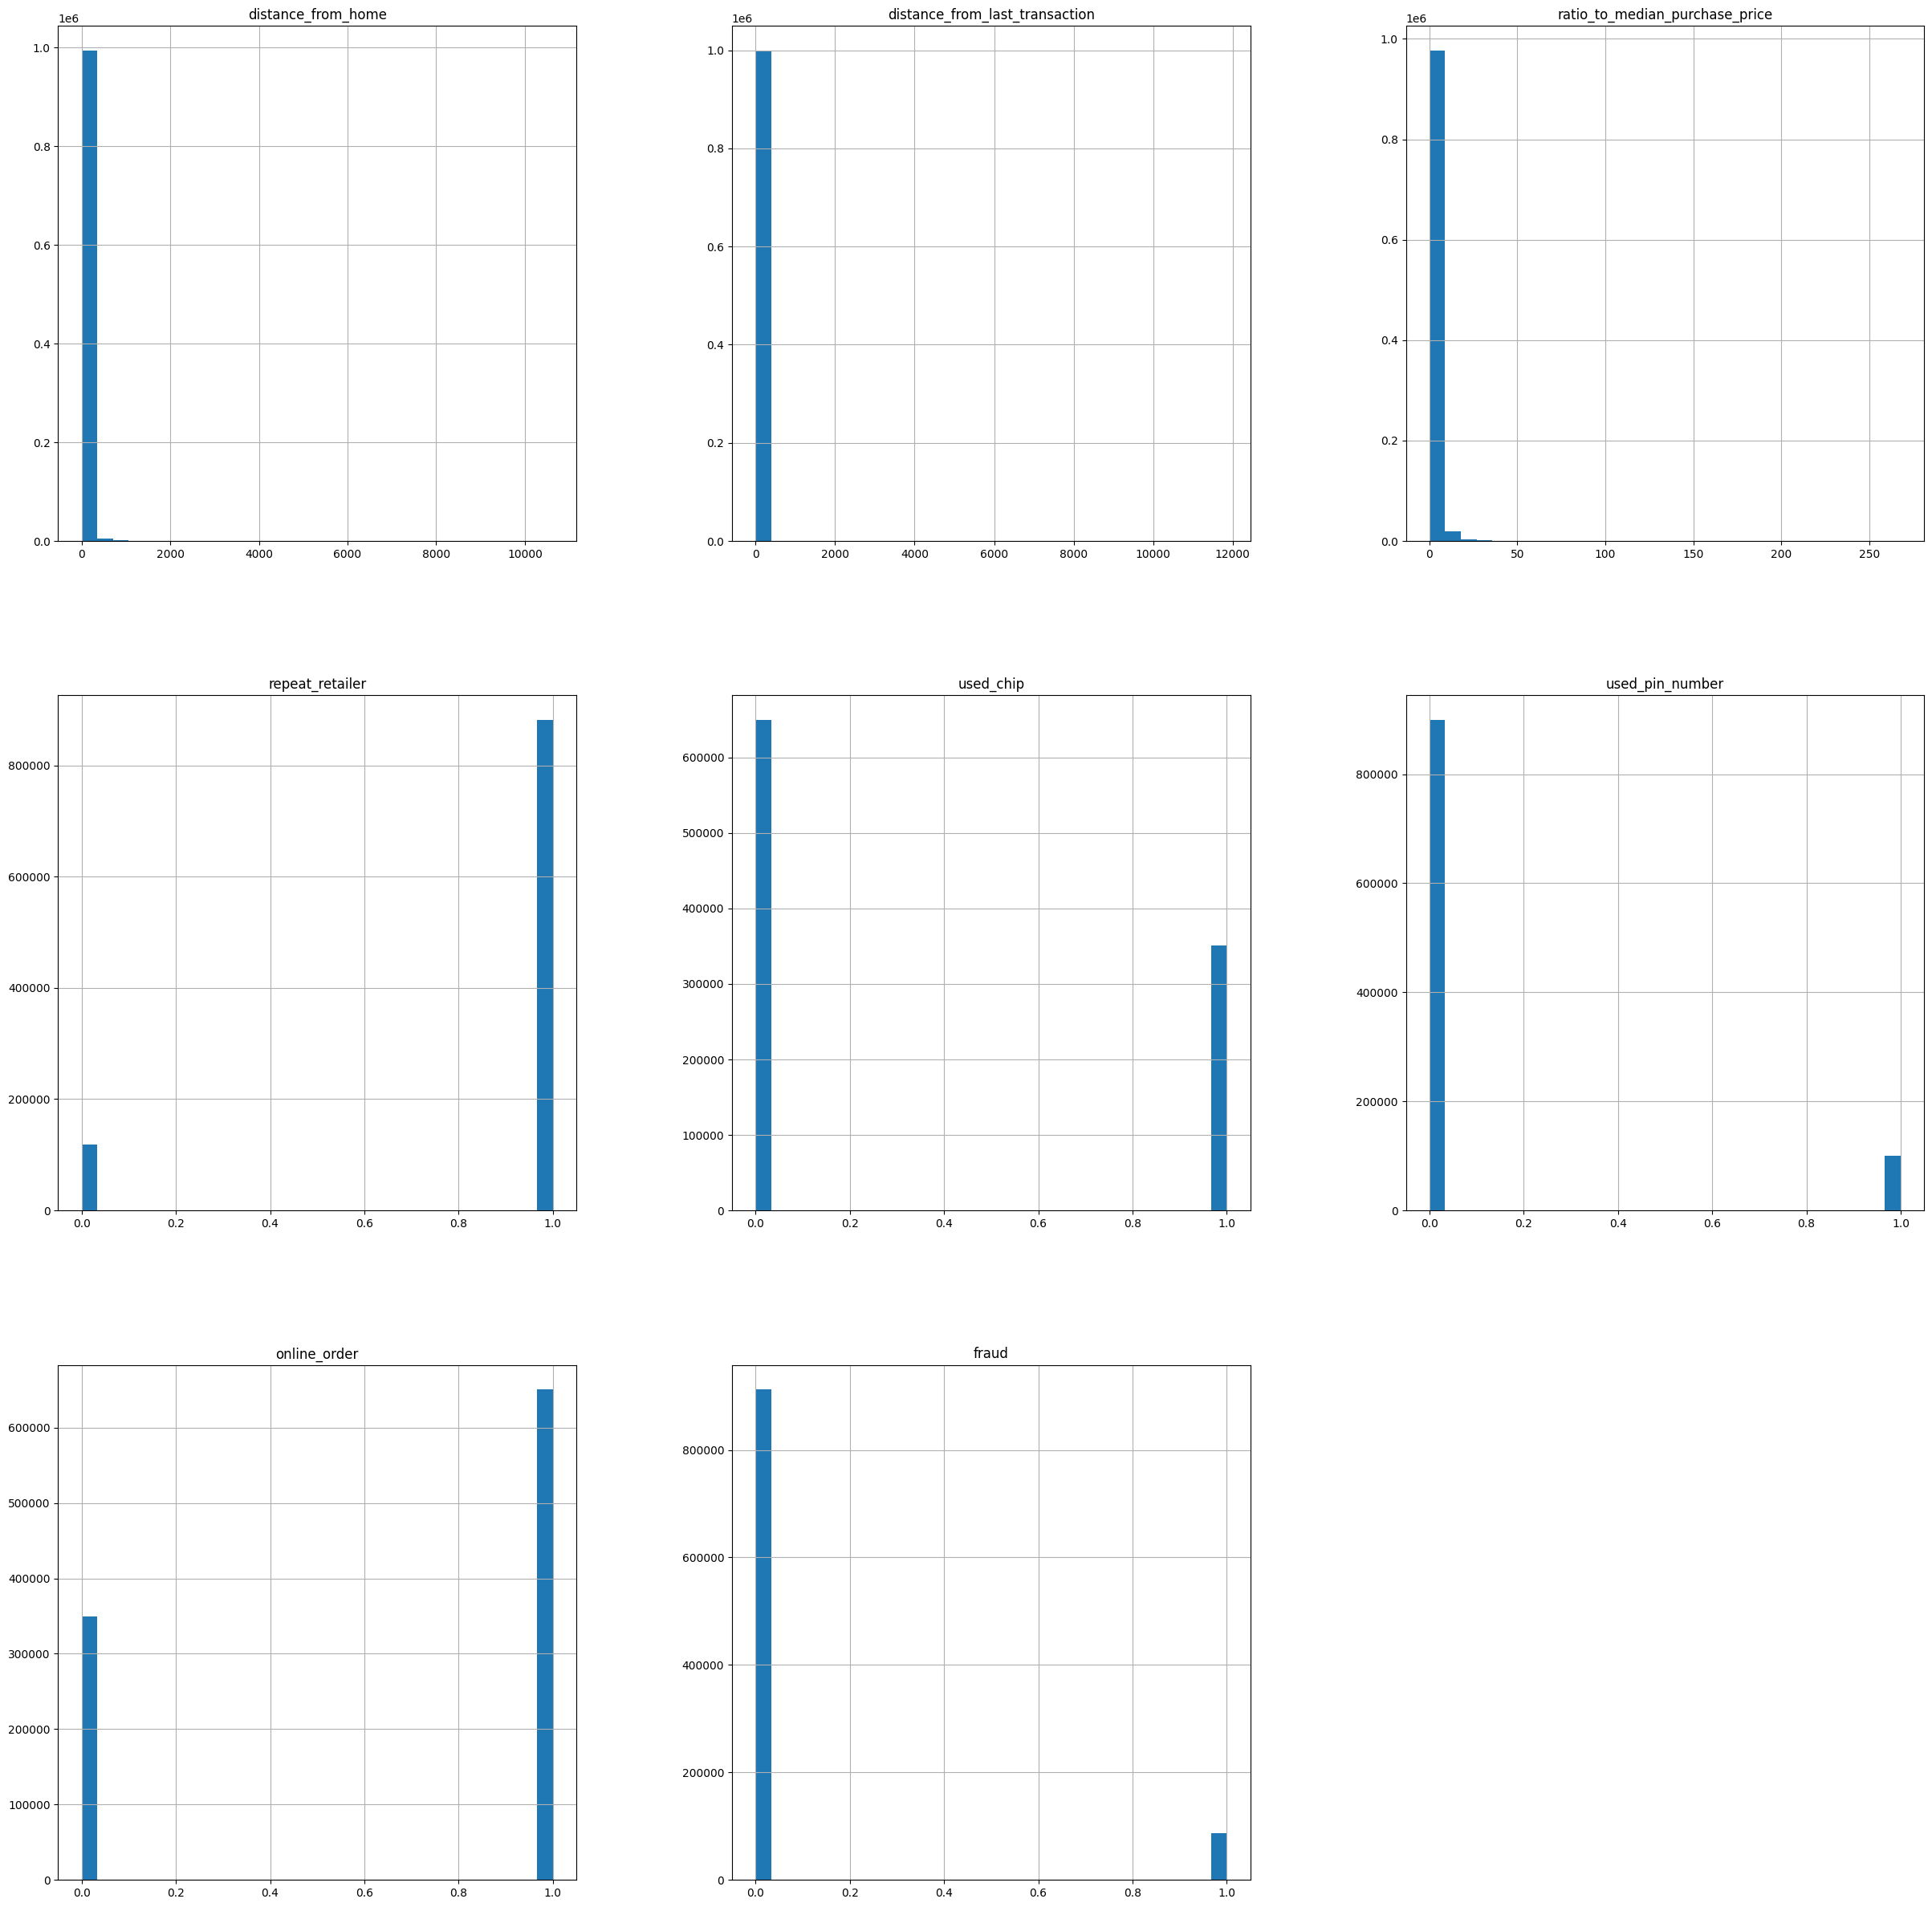

In [8]:
df.hist(bins = 30, figsize=(30,30))

# Data Cleaning

array([[<Axes: title={'center': 'distance_from_home'}>,
        <Axes: title={'center': 'distance_from_last_transaction'}>,
        <Axes: title={'center': 'ratio_to_median_purchase_price'}>],
       [<Axes: title={'center': 'repeat_retailer'}>,
        <Axes: title={'center': 'used_chip'}>,
        <Axes: title={'center': 'used_pin_number'}>],
       [<Axes: title={'center': 'online_order'}>,
        <Axes: title={'center': 'fraud'}>, <Axes: >]], dtype=object)

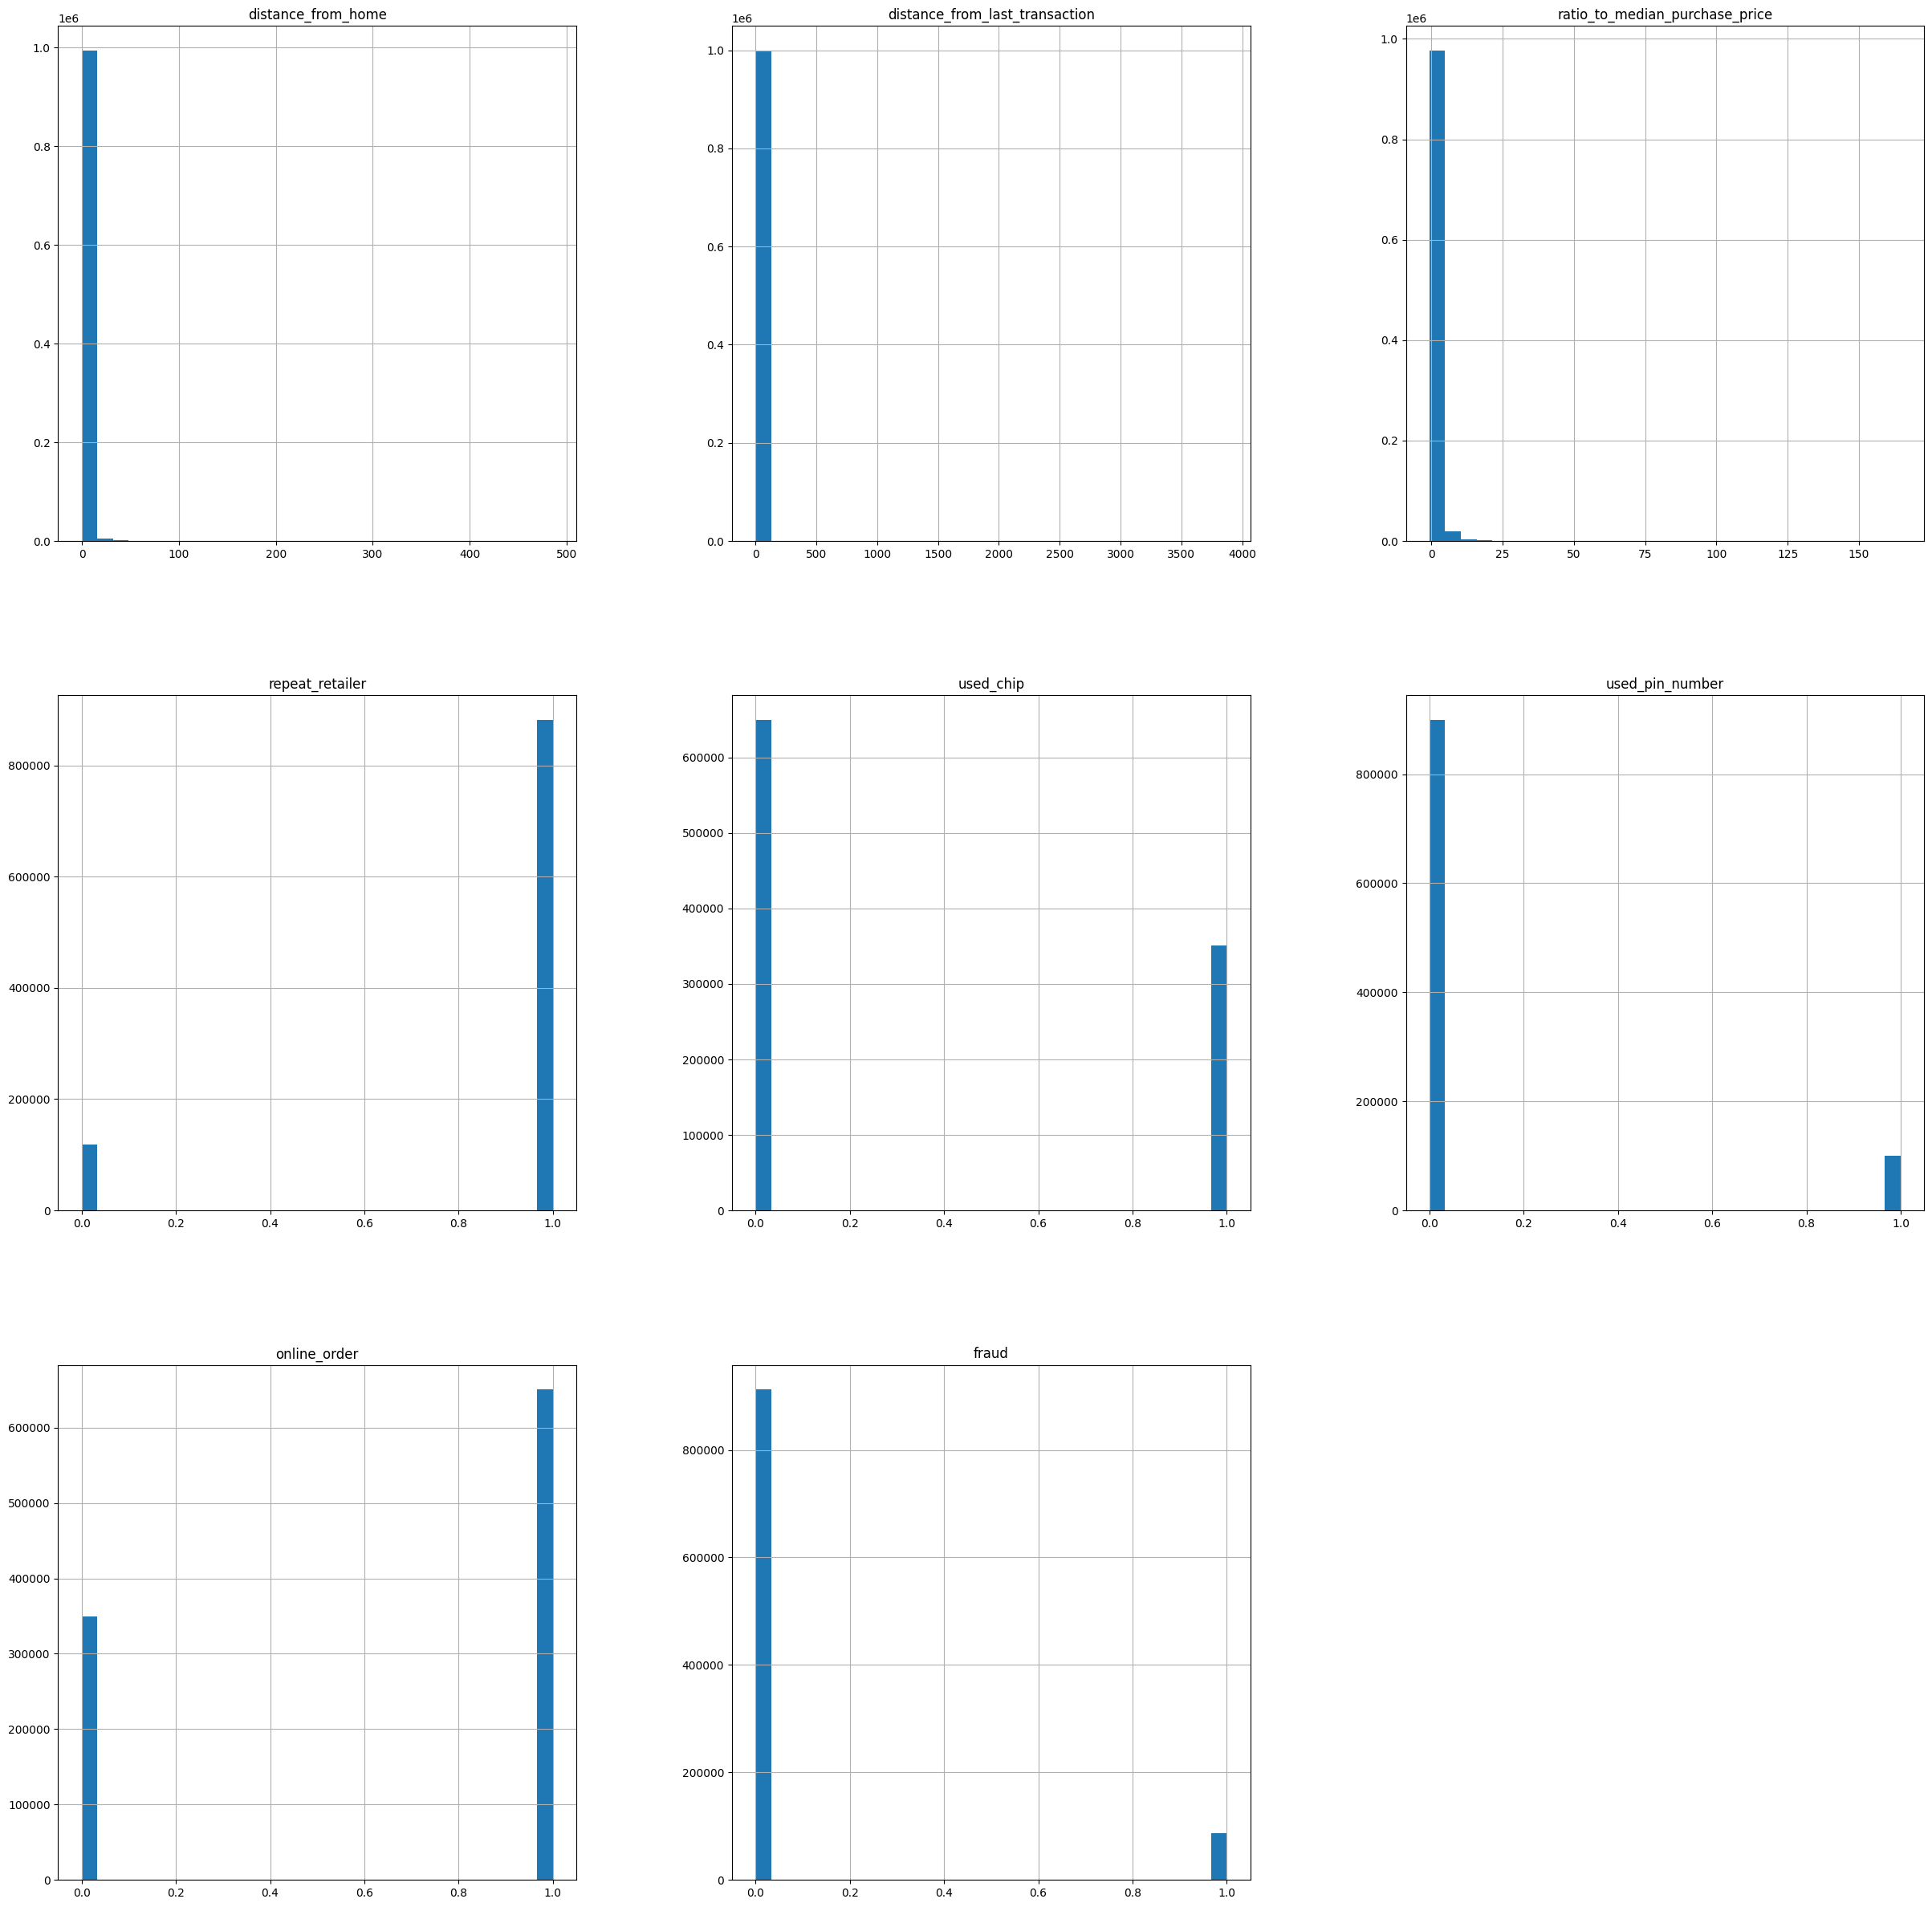

In [9]:
# Robust scaling of amount
new_df = df.copy()
new_df['distance_from_home'] = RobustScaler().fit_transform(new_df['distance_from_home']. to_numpy().reshape(-1,1))
new_df['distance_from_last_transaction'] = RobustScaler().fit_transform(new_df['distance_from_last_transaction']. to_numpy().reshape(-1,1))
new_df['ratio_to_median_purchase_price'] = RobustScaler().fit_transform(new_df['ratio_to_median_purchase_price']. to_numpy().reshape(-1,1))

new_df.hist(bins = 30, figsize=(30,30))

# Analysis with Unbalanced Data


## Train, Test, Validation split

In [10]:
# Creating train (70%), validation (20%), and test (10%) sets
train, val = model_selection.train_test_split(new_df, stratify=new_df['fraud'], test_size = 0.2)
train, test = model_selection.train_test_split(train, stratify = train['fraud'], test_size = 0.125)

In [11]:
train['fraud'].describe()

count    700000.000000
mean          0.087403
std           0.282425
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fraud, dtype: float64

In [12]:
val['fraud'].describe()

count    200000.000000
mean          0.087405
std           0.282428
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fraud, dtype: float64

In [13]:
test['fraud'].describe()

count    100000.000000
mean          0.087400
std           0.282422
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fraud, dtype: float64

In [14]:
train_np, test_np, val_np = train.to_numpy(), test.to_numpy(), val.to_numpy()
train_np.shape, test_np.shape, val_np.shape

((700000, 8), (100000, 8), (200000, 8))

In [15]:
x_train, y_train = train_np[:, :-1], train_np[:, -1]
x_test, y_test = test_np[:, :-1], test_np[:, -1]
x_val, y_val = val_np[:, :-1], val_np[:, -1]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((700000, 7), (700000,), (100000, 7), (100000,), (200000, 7), (200000,))

## Modeling

### Logistic regression

In [16]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
logistic_model.score(x_train, y_train)

0.9586757142857143

In [17]:
print(classification_report(y_val, logistic_model.predict(x_val), target_names = ['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.96      0.99      0.98    182519
       Fraud       0.89      0.60      0.72     17481

    accuracy                           0.96    200000
   macro avg       0.93      0.80      0.85    200000
weighted avg       0.96      0.96      0.96    200000



### Shallow neural network

In [18]:
shallow_nn = Sequential()
shallow_nn.add(InputLayer((x_train.shape[1], )))
shallow_nn.add(Dense(2, 'relu'))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(1, 'sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn', save_best_only = True)
shallow_nn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
shallow_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 16        
                                                                 
 batch_normalization (Batch  (None, 2)                 8         
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 27 (108.00 Byte)
Trainable params: 23 (92.00 Byte)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


In [20]:
shallow_nn.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=5, callbacks=checkpoint)

Epoch 1/5
21875/21875 [==============================] - 58s 3ms/step - loss: 0.1621 - accuracy: 0.9406 - val_loss: 0.1438 - val_accuracy: 0.9422
Epoch 2/5
21875/21875 [==============================] - 57s 3ms/step - loss: 0.1458 - accuracy: 0.9471 - val_loss: 0.1384 - val_accuracy: 0.9472
Epoch 3/5
21875/21875 [==============================] - 58s 3ms/step - loss: 0.1462 - accuracy: 0.9470 - val_loss: 0.1370 - val_accuracy: 0.9510
Epoch 4/5
21875/21875 [==============================] - 57s 3ms/step - loss: 0.1454 - accuracy: 0.9474 - val_loss: 0.1367 - val_accuracy: 0.9498
Epoch 5/5
21875/21875 [==============================] - 58s 3ms/step - loss: 0.1455 - accuracy: 0.9471 - val_loss: 0.1436 - val_accuracy: 0.9418


In [21]:
def neural_net_predictions(model, x):
  return (shallow_nn.predict(x).flatten() > 0.5).astype(int)

neural_net_predictions(shallow_nn, x_val)

6250/6250 [==============================] - 9s 1ms/step


array([0, 1, 0, ..., 0, 0, 0])

In [22]:
print(classification_report(y_val, neural_net_predictions(shallow_nn, x_val), target_names = ['Not Fraud','Fraud']))

6250/6250 [==============================] - 9s 1ms/step
              precision    recall  f1-score   support

   Not Fraud       0.94      0.99      0.97    182519
       Fraud       0.87      0.39      0.54     17481

    accuracy                           0.94    200000
   macro avg       0.91      0.69      0.75    200000
weighted avg       0.94      0.94      0.93    200000



### Random Forest

In [23]:
rf = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf.fit(x_train, y_train)
print(classification_report(y_val, rf.predict(x_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.92      1.00      0.96    182519
       Fraud       1.00      0.10      0.18     17481

    accuracy                           0.92    200000
   macro avg       0.96      0.55      0.57    200000
weighted avg       0.93      0.92      0.89    200000



### Gradient Boosting Classifier

In [24]:
gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate = 1.0, max_depth=1 , random_state=0)

gbc.fit(x_train, y_train)
print(classification_report(y_val, gbc.predict(x_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.97      0.96      0.97    182519
       Fraud       0.63      0.74      0.68     17481

    accuracy                           0.94    200000
   macro avg       0.80      0.85      0.82    200000
weighted avg       0.94      0.94      0.94    200000



### Support Vector Machine Classifier

In [25]:
svc = LinearSVC(class_weight = 'balanced')
svc.fit(x_train, y_train)
print(classification_report(y_val, svc.predict(x_val), target_names=['Not Fraud', 'Fraud']))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       0.99      0.94      0.97    182519
       Fraud       0.60      0.94      0.73     17481

    accuracy                           0.94    200000
   macro avg       0.80      0.94      0.85    200000
weighted avg       0.96      0.94      0.95    200000



### Model scores
(Precision, recall, f1-score, support)

**Shallow nn**
   
    Not Fraud       0.97      1.00      0.98    182519
           Fraud       0.94      0.73      0.82     17481

**svm**
    
    Not Fraud       0.99      0.94      0.97    182519
           Fraud       0.60      0.94      0.73     17481

**gbc**

    Not Fraud       0.98      0.96      0.97    182519
           Fraud       0.63      0.74      0.68     17481

**Logistic**     

    Not Fraud       0.96      0.99      0.98    182519
           Fraud       0.90      0.60      0.72     17481


**random forest**  

    Not Fraud       0.92      1.00      0.96    182519
           Fraud       1.00      0.04      0.09     17481

# Analysis with Unbalanced Data

## Processing

In [27]:
# downscaling not fraudulent transactions
not_frauds = new_df.query('fraud == 0')
frauds = new_df.query('fraud == 1')
not_frauds['fraud'].value_counts(), frauds['fraud'].value_counts()

(0.0    912597
 Name: fraud, dtype: int64,
 1.0    87403
 Name: fraud, dtype: int64)

In [28]:
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df['fraud'].value_counts()

1.0    87403
0.0    87403
Name: fraud, dtype: int64

In [29]:
balanced_df = balanced_df.sample(frac=1, random_state =1 )

In [30]:
balanced_df['fraud'] = balanced_df['fraud'].astype(int)

In [31]:
balanced_df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
985779,-0.433353,0.449790,-0.395139,0.0,0.0,0.0,1.0,0
738377,0.926008,-0.193492,0.273123,1.0,0.0,0.0,1.0,0
882426,-0.046511,0.371115,0.040966,1.0,0.0,0.0,1.0,0
787107,7.361619,0.235172,5.879320,1.0,0.0,0.0,1.0,1
880136,0.976982,1.834937,5.750498,1.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...
838967,-0.343476,0.291259,3.339705,1.0,0.0,0.0,1.0,1
557401,-0.114701,0.267531,-0.001980,1.0,0.0,0.0,1.0,0
572209,5.180387,-0.251034,-0.294993,1.0,0.0,0.0,1.0,1
60119,-0.109250,0.923129,4.753717,1.0,1.0,0.0,1.0,1


## Train, Test, Validation Split

In [32]:
# Creating train (70%), validation (20%), and test (10%) sets
train_b, val_b = model_selection.train_test_split(balanced_df, stratify=balanced_df['fraud'], test_size = 0.2)
train_b, test_b = model_selection.train_test_split(train_b, stratify = train_b['fraud'], test_size = 0.125)

In [33]:
train_b['fraud'].describe()

count    122363.000000
mean          0.500004
std           0.500002
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: fraud, dtype: float64

In [34]:
val_b['fraud'].describe()

count    34962.000000
mean         0.500000
std          0.500007
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: fraud, dtype: float64

In [35]:
test_b['fraud'].describe()

count    17481.000000
mean         0.499971
std          0.500014
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: fraud, dtype: float64

In [36]:
train_b_np, test_b_np, val_b_np = train_b.to_numpy().astype(int), test_b.to_numpy().astype(int), val_b.to_numpy().astype(int)
train_b_np.shape, test_b_np.shape, val_b_np.shape

((122363, 8), (17481, 8), (34962, 8))

In [37]:
x_train_b, y_train_b = train_b_np[:, :-1], train_b_np[:, -1]
x_test_b, y_test_b = test_b_np[:, :-1], test_b_np[:, -1]
x_val_b, y_val_b = val_b_np[:, :-1], val_b_np[:, -1]

x_train_b.shape, y_train_b.shape, x_test_b.shape, y_test_b.shape, x_val_b.shape, y_val_b.shape

((122363, 7), (122363,), (17481, 7), (17481,), (34962, 7), (34962,))

In [38]:
pd.Series(y_train_b).value_counts(), pd.Series(y_test_b).value_counts(), pd.Series(y_val_b).value_counts()

(1    61182
 0    61181
 dtype: int64,
 0    8741
 1    8740
 dtype: int64,
 1    17481
 0    17481
 dtype: int64)

## Modeling

### Logistic Regression

In [39]:
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_b, y_train_b)
print(classification_report(y_val_b, logistic_model_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.96      0.94      0.95     17481
       Fraud       0.94      0.96      0.95     17481

    accuracy                           0.95     34962
   macro avg       0.95      0.95      0.95     34962
weighted avg       0.95      0.95      0.95     34962



### Shallow neural network

In [41]:
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer((x_train_b.shape[1], )))
shallow_nn_b.add(Dense(2, 'relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, 'sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_b', save_best_only = True)
shallow_nn_b.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
shallow_nn_b.fit(x_train_b, y_train_b, validation_data = (x_val_b, y_val_b), epochs=20, callbacks=checkpoint)

Epoch 1/20
3824/3824 [==============================] - 17s 3ms/step - loss: 0.3136 - accuracy: 0.8961 - val_loss: 0.2053 - val_accuracy: 0.9508
Epoch 2/20
3824/3824 [==============================] - 16s 4ms/step - loss: 0.2116 - accuracy: 0.9328 - val_loss: 0.1711 - val_accuracy: 0.9429
Epoch 3/20
3824/3824 [==============================] - 13s 3ms/step - loss: 0.2002 - accuracy: 0.9340 - val_loss: 0.1628 - val_accuracy: 0.9435
Epoch 4/20
3824/3824 [==============================] - 11s 3ms/step - loss: 0.1993 - accuracy: 0.9342 - val_loss: 0.1666 - val_accuracy: 0.9409
Epoch 5/20
3824/3824 [==============================] - 12s 3ms/step - loss: 0.1990 - accuracy: 0.9338 - val_loss: 0.1550 - val_accuracy: 0.9442
Epoch 6/20
3824/3824 [==============================] - 12s 3ms/step - loss: 0.1976 - accuracy: 0.9335 - val_loss: 0.1550 - val_accuracy: 0.9588
Epoch 7/20
3824/3824 [==============================] - 12s 3ms/step - loss: 0.1981 - accuracy: 0.9347 - val_loss: 0.1544 - val_ac

In [42]:
print(classification_report(y_val_b, neural_net_predictions(shallow_nn_b, x_val_b), target_names = ['Not Fraud','Fraud']))

1093/1093 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

   Not Fraud       0.59      1.00      0.74     17481
       Fraud       0.99      0.32      0.48     17481

    accuracy                           0.66     34962
   macro avg       0.79      0.66      0.61     34962
weighted avg       0.79      0.66      0.61     34962



### Random forest

In [43]:
rf_b = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_b.fit(x_train_b, y_train_b)
print(classification_report(y_val_b, rf_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.89      0.96      0.92     17481
       Fraud       0.95      0.88      0.92     17481

    accuracy                           0.92     34962
   macro avg       0.92      0.92      0.92     34962
weighted avg       0.92      0.92      0.92     34962



### Gradient Boosting Classifier

In [44]:
gbc_b = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth=2 , random_state=0)

gbc_b.fit(x_train_b, y_train_b)
print(classification_report(y_val_b, gbc_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.98      0.96      0.97     17481
       Fraud       0.96      0.98      0.97     17481

    accuracy                           0.97     34962
   macro avg       0.97      0.97      0.97     34962
weighted avg       0.97      0.97      0.97     34962



### Support Vector Machine Classifier

In [45]:
svc_b = LinearSVC(class_weight = 'balanced')
svc_b.fit(x_train_b, y_train_b)
print(classification_report(y_val_b, svc_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.94      0.95      0.95     17481
       Fraud       0.95      0.94      0.95     17481

    accuracy                           0.95     34962
   macro avg       0.95      0.95      0.95     34962
weighted avg       0.95      0.95      0.95     34962



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


###Model scores
(Precision, recall, F1-score, support)

**GBC**

    Not Fraud       0.98      0.96      0.97     17481
           Fraud       0.96      0.98      0.97     17481

**Logistic Regression**

    Not Fraud       0.96      0.94      0.95     17481
           Fraud       0.94      0.96      0.95     17481


**Linear SVM**

    Not Fraud       0.94      0.95      0.95     17481
           Fraud       0.95      0.94      0.95     17481

**Random Forest**

    Not Fraud       0.89      0.96      0.92     17481
           Fraud       0.95      0.88      0.92     17481

**Shallow nn**

    Not Fraud       0.59      1.00      0.74     17481
           Fraud       0.99      0.32      0.48     17481

# Test

In [46]:
print(classification_report(y_test_b, svc_b.predict(x_test_b), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.94      0.96      0.95      8741
       Fraud       0.96      0.93      0.94      8740

    accuracy                           0.95     17481
   macro avg       0.95      0.95      0.95     17481
weighted avg       0.95      0.95      0.95     17481



## Score
Using the gbc model from the balanced dataset

    Not Fraud       0.94      0.96      0.95      8741
           Fraud       0.96      0.93      0.94      8740

The model performed with around 90% accuracy.